In [62]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import applications
from keras.layers import Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D, BatchNormalization
import visualkeras

In [46]:
class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, w1, w2, w3, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3

    def call(self, inputs):
        return self.w1 * inputs[0] + self.w2 * inputs[1] +self.w3 * inputs[2]

In [47]:
labels_csv = pd.read_csv('labels.csv')
labels_csv["id"] = [fname + ".jpg" for fname in labels_csv["id"]]
data_train = pathlib.Path('train')
data_test = pathlib.Path('test')

In [48]:
batch_size = 16
img_size = 224

In [49]:
datagen = ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input, validation_split=0.2)
train_generator = datagen.flow_from_dataframe(
                        dataframe = labels_csv,
                        directory = data_train,
                        subset="training",
                        x_col="id",
                        y_col="breed",
                        batch_size=batch_size,
                        shuffle=True,
                        class_mode="sparse",
                        color_mode="rgb",
                        target_size=(img_size, img_size))

validation_generator = datagen.flow_from_dataframe(
                        dataframe = labels_csv,
                        directory = data_train,
                        subset="validation",
                        x_col="id",
                        y_col="breed",
                        batch_size=batch_size,
                        shuffle=True,
                        class_mode="sparse",
                        color_mode="rgb",
                        target_size=(img_size, img_size))

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


In [50]:
vgg16 = applications.vgg16.VGG16(include_top=False, weights='imagenet',input_shape=(224,224,3))
resnet50 = keras.applications.ResNet50(include_top=False, weights='imagenet',input_shape=(224,224,3))
inceptionV3 = applications.inception_v3.InceptionV3(include_top=False, weights='imagenet',input_shape=(224,224,3))

for layer in vgg16 .layers:
    layer.trainable=False
for layer in resnet50.layers:
    layer.trainable=False
for layer in inceptionV3.layers:
    layer.trainable=False

model1 = Sequential()
model2 = Sequential()
model3 = Sequential()

model1.add(vgg16)
model1.add(BatchNormalization())
model1.add(GlobalAveragePooling2D())
model1.add(Dropout(0.5))
model1.add(Dense(1024, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(120, activation='softmax'))

model2.add(resnet50)
model2.add(BatchNormalization())
model2.add(GlobalAveragePooling2D())
model2.add(Dropout(0.5))
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(120, activation='softmax'))

model3.add(inceptionV3)
model3.add(BatchNormalization())
model3.add(GlobalAveragePooling2D())
model3.add(Dropout(0.5))
model3.add(Dense(1024, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(120, activation='softmax'))

optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001)
model1.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
model2.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
model3.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
# model1.save('model1.h5')
# model2.save('model2.h5')
# model3.save('model3.h5')

# history_vgg = model1.fit(train_generator, epochs=20, verbose = 1,
#                          validation_data=validation_generator)
#
# history_res = model2.fit(train_generator, epochs=20, verbose = 1,
#                        validation_data=validation_generator)
#
# history_inc = model3.fit(train_generator, epochs=20, verbose = 1,
#                         validation_data=validation_generator)


In [58]:
models = [model1,model2,model3]
model_input = tf.keras.Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)
ensemble_model.compile(optimizer=optimizer,
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])
ensemble_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_21 (Sequential)     (None, 120)          15535288    ['input_39[0][0]']               
                                                                                                  
 sequential_22 (Sequential)     (None, 120)          25817080    ['input_39[0][0]']               
                                                                                                  
 sequential_23 (Sequential)     (None, 120)          24032152    ['input_39[0][0]']        

In [59]:
history_ens = ensemble_model.fit(train_generator, epochs=20, verbose = 1,
                                 validation_data=validation_generator)

Epoch 1/20
512/512 [==============================] - 50s 90ms/step - loss: 5.1049 - accuracy: 0.0152 - val_loss: 4.4649 - val_accuracy: 0.0416
Epoch 2/20
512/512 [==============================] - 45s 87ms/step - loss: 4.0275 - accuracy: 0.1156 - val_loss: 3.2712 - val_accuracy: 0.2544
Epoch 3/20
512/512 [==============================] - 45s 87ms/step - loss: 3.0726 - accuracy: 0.3040 - val_loss: 2.4885 - val_accuracy: 0.4511
Epoch 4/20
512/512 [==============================] - 44s 87ms/step - loss: 2.5074 - accuracy: 0.4331 - val_loss: 2.1646 - val_accuracy: 0.5250
Epoch 5/20
512/512 [==============================] - 44s 87ms/step - loss: 2.2383 - accuracy: 0.4990 - val_loss: 1.9866 - val_accuracy: 0.5773
Epoch 6/20
512/512 [==============================] - 44s 87ms/step - loss: 2.0577 - accuracy: 0.5437 - val_loss: 1.8909 - val_accuracy: 0.5837
Epoch 7/20
512/512 [==============================] - 44s 87ms/step - loss: 1.9403 - accuracy: 0.5681 - val_loss: 1.8122 - val_accuracy:

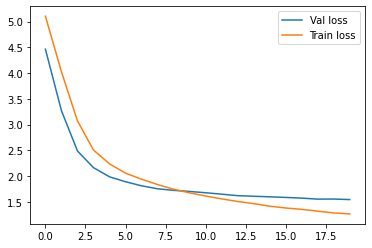

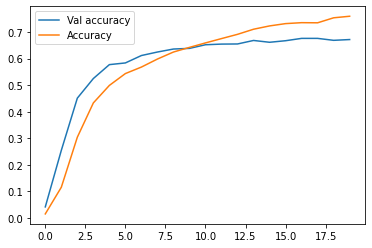

In [60]:
plt.figure()
plt.plot(history_ens .history["val_loss"], label = "Val loss")
plt.plot(history_ens .history["loss"], label = "Train loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(history_ens .history["val_accuracy"], label = "Val accuracy")
plt.plot(history_ens .history["accuracy"], label = "Accuracy")
plt.legend()
plt.show()

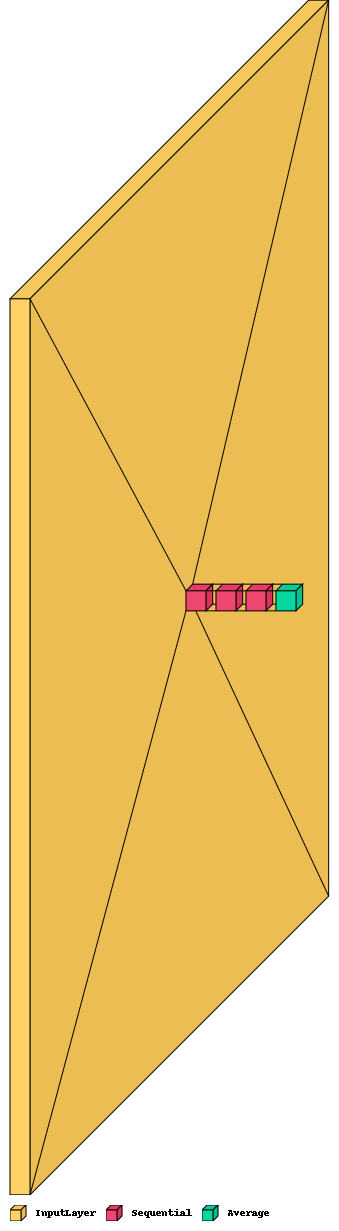

In [63]:
visualkeras.layered_view(ensemble_model,  legend=True)